In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as mat
import plotly.graph_objects as go
import sympy as sym
import seaborn as sns
import scipy.stats as ss
import random

In [2]:
sns.set_style('whitegrid')
sns.set_palette('deep')

In [3]:
def M(x):
    x_vec = sym.Matrix(x)
    dim = len(x)
    return sym.Matrix(sym.BlockMatrix([[sym.ZeroMatrix(dim, dim), x_vec],[x_vec.T, sym.ZeroMatrix(1,1)]]))

def o(dim):
    return sym.Matrix(np.eye(dim, dtype='int64')[-1])

In [4]:
def LinearDevelopment(theta, L):
    """
    Parameterized such that ||theta|| = 1
    """
    dim = len(theta)
    theta = sym.Matrix(theta)
    
    out = sym.BlockMatrix([[(sym.cosh(L) - 1)*(theta*theta.T) + sym.eye(dim), sym.sinh(L)*theta],
                           [sym.sinh(L)*theta.T, sym.Matrix([sym.cosh(L)])]])
    
    return sym.Matrix(out)

def LinearDevelopmentSeries(theta, L, terms = 10):
    """
    Parameterized such that ||theta|| = 1
    """

    dim = len(theta)
    theta = sym.Matrix(theta)
    M_x = sym.Matrix(sym.BlockMatrix([[sym.zeros(dim, dim), L*theta],[L*theta.T,sym.zeros(1)]]))
    exp_series = []
    for i in range(terms):
        exp_series.append(M_x.pow(i)/sym.factorial(i))
    return exp_series

In [5]:
def ScaledSeries(A, lam):
    out = []
    for i in range(len(A)):
        out.append((lam**i)*A[i])
    
    return out

def SeriesProd(A, B):
    
    if len(A)!=len(B) or A[0].shape[0] != B[0].shape[0]:
        raise ValueError('Series must be of the same length and dimension')
    
    dim = A[0].shape[0]
    out = []
    for k in range(len(A)):
        D_k = sym.zeros(dim,dim)
            
        i=0
        while i <= k:
            D_k += A[i]*B[k-i]
            i+=1

        out.append(D_k)

    return out

def ProdList(series_list):

    for i in range(len(series_list)-1):
        if len(series_list[i])!=len(series_list[i+1]):
            raise ValueError('Series must be of the same length')
    
    prod = series_list[0].copy()
    for i in range(1,len(series_list)):
        prod = SeriesProd(prod, series_list[i])
        
    return prod

def SeriesSum(A):
    dim = A[0].shape[0]
    return sum(A, sym.zeros(dim, dim))

In [8]:
def PathDevelopment(thetas, ls):
    """
    Development of a piecewise linear path specified using angles and corresponding lengths
    -----------------------------------
    thetas -- array-like: two dimensional array with elements corresponding to the direction of each segment
    ls -- list: lengths of each path segment
    """

    prod = o(len(thetas[0])+1)
    for i in zip(thetas[::-1], ls[::-1]):
        prod = LinearDevelopment(i[0], i[1])*prod
    return prod


def PathDevelopmentSeries(coords, terms, axis=True):
    """Series representation of the development of a piecewise linear path"""
    exps = []

    diffs = np.diff(np.array(coords)).T
    
    for i in range(len(coords[0])-1):
        theta = diffs[i]
        if axis:
            theta = theta.astype('int')

        L = sym.Matrix.norm(sym.Matrix(theta))
        theta = theta/L
        exps.append(LinearDevelopmentSeries(theta, L, terms))

    return ProdList(exps)

def InvertLatticePathDevelopment(D, length, lam, dim):
    directions = np.append(np.eye(dim),-np.eye(dim), axis=0)
    thetas = []
    for i in range(length):
        theta = np.array(D/sym.sinh(sym.acosh(D[-1]))).astype('float64')[:-1]
        theta = directions[np.argmin([np.linalg.norm(theta.T-e_i) for e_i in directions])].astype('int')
        thetas.append(theta)
        print(theta)
        D = sym.simplify(LinearDevelopment(-theta, lam) * D)
    coords = np.append(np.zeros((dim,1)), (np.array(thetas)).T,axis=1).cumsum(axis=1)
    return coords

def InvertLatticeDevelopmentSeries(D, length, lam1 = 5, lam2=0.5):
    terms = len(D)
    dim = D[0].shape[0] - 1
    o = sym.Matrix(np.eye(dim+1, dtype='int')[-1])
    directions = np.append(np.eye(dim, dtype='int'),-np.eye(dim, dtype='int'), axis=0)
    thetas = []
    
    D_ = ScaledSeries(D, sym.Rational(lam2))
    for i in range(length):
        tmp = D_.copy()
        p = SeriesSum(ScaledSeries(tmp, sym.Rational(lam1, lam2))) * o
        
        theta_hat = (np.array(p[:-1])/sym.sinh(sym.acosh(p[-1]))).astype('float64')
        closest = np.argmin([np.linalg.norm(e_i-theta_hat) for e_i in directions])
        
        theta = directions[closest]
        print(f'Slope {i} = {theta}')
        thetas.append(theta)

        D_ = SeriesProd(LinearDevelopmentSeries(-theta, sym.Rational(lam2), terms), tmp)
      
    coords = np.append(np.zeros((dim,1)), np.array(thetas).T, axis=1).cumsum(axis=1)
    return coords

In [7]:
def GenerateRandomPath(length, dim):
    """generates a random lattice path of specified length and dimension"""
    
    e_i = []
    directions = np.eye(dim, dtype='int')
    curr = np.random.choice(np.arange(dim))
    e_i.append(directions[curr]*random.choice([-1,1]))
    for i in range(1, length):
        curr = np.random.choice(np.arange(dim)[np.arange(dim)!=curr])
        e_i.append(directions[curr]*random.choice([1,-1]))
    
    return np.array(e_i)


def GenerateRandomPathCoords(length, dim):
    """generates coordinates of a random lattice path of specified length and dimension"""

    e_i = [np.zeros(dim)]
    directions = np.eye(dim, dtype='int')
    curr = np.random.choice(np.arange(dim))
    e_i.append(directions[curr]*random.choice([-1,1]))
    for i in range(1, length):
        curr = np.random.choice(np.arange(dim)[np.arange(dim)!=curr])
        e_i.append(directions[curr]*random.choice([1,-1]))
    
    return np.array(e_i).cumsum(axis=0).T

#### Convergence of Direction/Length Approximations

In [40]:
l = sym.Symbol('l')
H = PathDevelopment([[1,0],[0,1],[1,0],[0,-1],[1,0]],[l,l,l,l,l])

In [14]:
rho_lam = [sym.acosh(H[-1]).subs(l,L).evalf()/L for L in np.arange(1,100,2)]

Text(0.5, 0, '$\\lambda$')

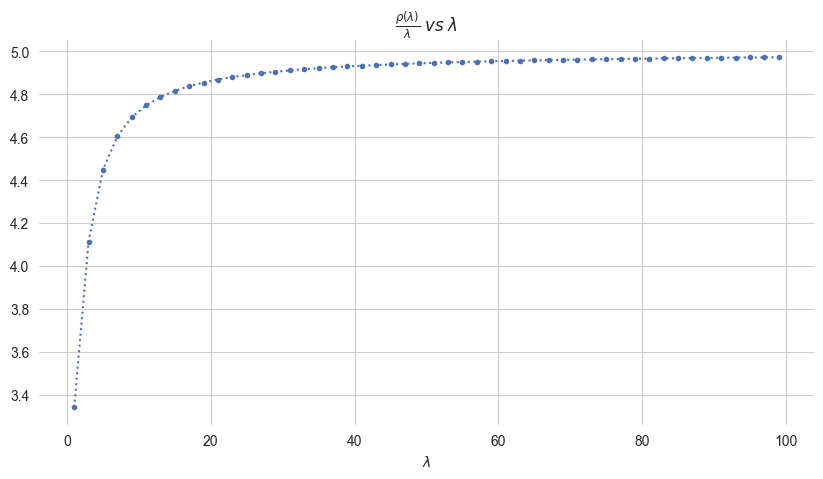

In [289]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,100,2),np.array(rho_lam),'o:', markersize=3)
sns.despine(left=True, bottom=True)

plt.title(r'$\frac{\rho(\lambda)}{\lambda} \;vs\; \lambda$')
plt.xlabel(r'$\lambda$')


In [22]:
L = sym.Symbol('L')
lam_arr = [1,2,3,5,7,10,15,20,25,30]
ls = [(sym.solve((LinearDevelopment([-1,0],L)*H)[0].subs(l,lam),L)[0]/lam) for lam in lam_arr]

In [23]:
theta_norms = [np.float64(sym.Matrix.norm((sym.Matrix(H[:2])/sym.sinh(sym.acosh(H[-1]))).subs(l,lam)-sym.Matrix([1,0]))) for lam in lam_arr]

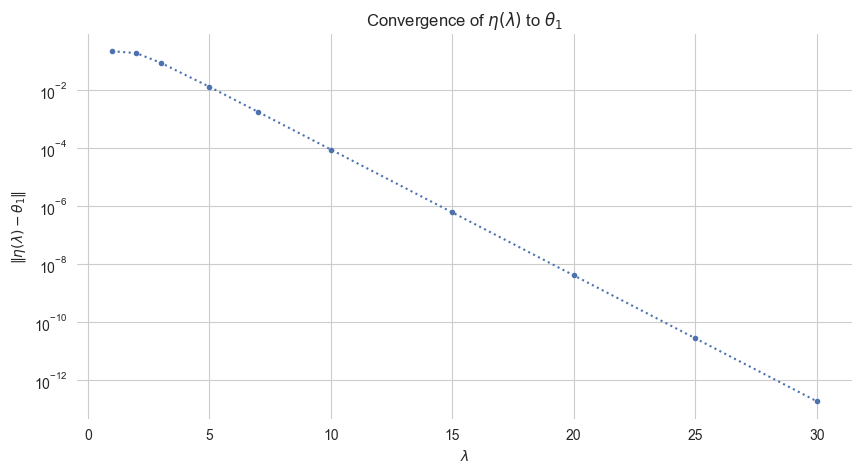

In [36]:
plt.figure(figsize=(10,5))
plt.plot(lam_arr,np.array([(norm) for norm in theta_norms]),'o:', markersize=3)

plt.title(r'Convergence of $\eta(\lambda)$ to $\theta_1$')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\|\eta(\lambda)-\theta_1\|$')
sns.despine(left=True, bottom=True)

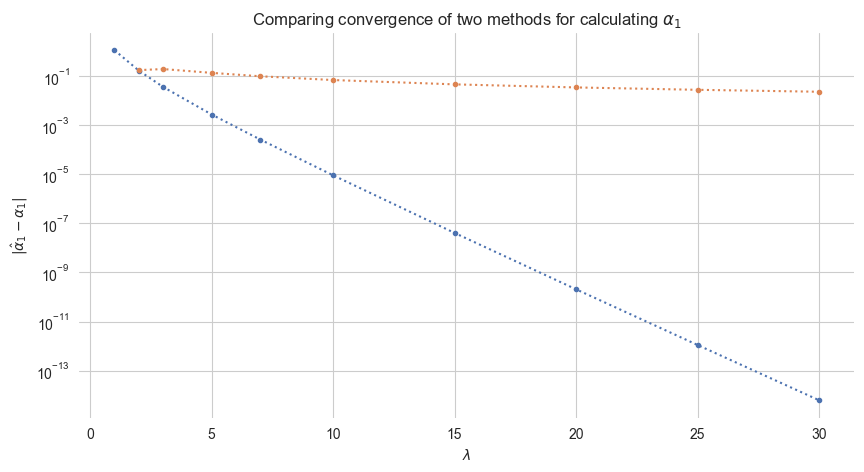

In [37]:
plt.figure(figsize=(10,5))
plt.plot(lam_arr, [l-1 for l in ls], 'o:', markersize=3, label='Method 2')
plt.plot(lam_arr[1:], 1+(np.array([sym.log(norm) for norm in theta_norms[1:]]))/np.array(lam_arr[1:]),
         'o:', markersize=3, label='Method 1')



plt.title(r'Comparing convergence of two methods for calculating $\alpha_1$')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$|\hat{\alpha}_1-\alpha_1|$')
sns.despine(left=True, bottom=True)

#### Inverting Simple Lattice Paths Using the Analytic Solution of the Hyperbolic Development

In [575]:
np.random.seed(42)
random.seed(42)
e_i = GenerateRandomPath(10, 3)

In [576]:
e_i

array([[ 0,  0, -1],
       [ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  1,  0],
       [ 1,  0,  0],
       [ 0,  0,  1],
       [ 1,  0,  0],
       [ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]])

In [580]:
D1 = sym.simplify(PathDevelopment(e_i, 1*np.ones(len(e_i)).astype('int'))) # lambda=1
D2 = sym.simplify(PathDevelopment(e_i, 2*np.ones(len(e_i)).astype('int'))) # lambda=2

In [581]:
coords_hat1 = InvertLatticePathDevelopment(D1,length=10,lam=1, dim=3) # lambda=1

[ 0  0 -1]
[0 1 0]
[0 1 0]
[-1  0  0]
[0 0 1]
[0 1 0]
[-1  0  0]
[0 0 1]
[1 0 0]
[-1  0  0]


In [583]:
coords_hat2 = InvertLatticePathDevelopment(D2,length=10,lam=2, dim=3) # lambda=2

[ 0  0 -1]
[0 1 0]
[-1  0  0]
[0 1 0]
[1 0 0]
[0 0 1]
[1 0 0]
[0 1 0]
[-1  0  0]
[0 0 1]


In [64]:
D = sym.simplify(PathDevelopment([[1,0,0],[0,1,0],[0,0,1],[1,0,0],[0,1,0],[0,0,1],[1,0,0],[0,1,0],[0,0,1],[1,0,0]],[1,1,1,1,1,1,1,1,1,1]))

In [65]:
coords = InvertLatticePathDevelopment(D,lam=1,dim=3,length=10)

[1 0 0]
[0 1 0]
[0 0 1]
[1 0 0]
[0 1 0]
[0 0 1]
[1 0 0]
[0 1 0]
[0 0 1]
[1 0 0]


#### Inverting the Series Representation of the Cartan Development

In [43]:
np.random.seed(42)
random.seed(42)
coords = GenerateRandomPathCoords(30, 10)

In [88]:
D = PathDevelopmentSeries(np.array(coords), 20, axis=True)

In [86]:
coords_hat = InvertLatticeDevelopmentSeries(D, 30, lam1=4, lam2=sym.Rational(1,5))

Slope 0 = [ 0  0  0  0  0  0 -1  0  0  0]
Slope 1 = [0 0 0 1 0 0 0 0 0 0]
Slope 2 = [ 0  0  0  0  0  0  0  0 -1  0]
Slope 3 = [0 0 0 0 1 0 0 0 0 0]
Slope 4 = [0 0 0 0 0 0 0 1 0 0]
Slope 5 = [0 0 1 0 0 0 0 0 0 0]
Slope 6 = [0 0 0 0 0 0 0 1 0 0]
Slope 7 = [0 0 0 0 0 0 0 0 1 0]
Slope 8 = [ 0  0  0  0 -1  0  0  0  0  0]
Slope 9 = [0 0 0 1 0 0 0 0 0 0]
Slope 10 = [0 0 0 0 0 0 0 0 1 0]
Slope 11 = [0 0 0 0 0 0 0 1 0 0]
Slope 12 = [0 0 1 0 0 0 0 0 0 0]
Slope 13 = [0 0 0 0 0 0 1 0 0 0]
Slope 14 = [0 0 0 0 1 0 0 0 0 0]
Slope 15 = [0 1 0 0 0 0 0 0 0 0]
Slope 16 = [ 0  0  0  0  0  0  0  0 -1  0]
Slope 17 = [0 0 0 0 0 1 0 0 0 0]
Slope 18 = [ 0 -1  0  0  0  0  0  0  0  0]
Slope 19 = [ 0  0  0  0  0 -1  0  0  0  0]
Slope 20 = [1 0 0 0 0 0 0 0 0 0]
Slope 21 = [0 0 0 0 0 0 1 0 0 0]
Slope 22 = [ 0  0  0  0  0  0  0  0  0 -1]
Slope 23 = [-1  0  0  0  0  0  0  0  0  0]
Slope 24 = [ 0  0  0 -1  0  0  0  0  0  0]
Slope 25 = [0 0 0 0 0 0 0 1 0 0]
Slope 26 = [0 0 0 1 0 0 0 0 0 0]
Slope 27 = [ 0  0  0  0  0  0

In [108]:
D = PathDevelopmentSeries([[0,1,1,1],[0,0,1,1],[0,0,0,1]],50)

In [119]:
p = SeriesSum(ScaledSeries(D,10))*o(4)
(np.array(p[:-1])/sym.sinh(sym.acosh(p[-1]))).astype('float64') # estimate eta

array([1.00027757e+00, 9.08596066e-05, 8.25003955e-09])

In [247]:
p2 = [SeriesSum(ScaledSeries(SeriesProd(LinearDevelopmentSeries([-1,0,0],L,50),D),10))*o(4) for L in np.linspace(0.9,1.1,50)]

In [248]:
etas = [sym.Matrix((np.array(p_[:-1])/sym.sinh(sym.acosh(p_[-1])))) for p_ in p2]

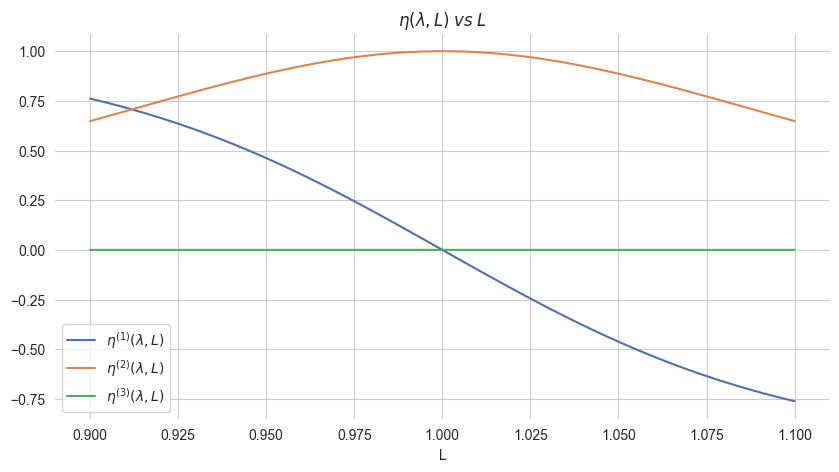

In [249]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0.9,1.1,50), np.array(etas).T[0].astype('float64').T)
plt.legend([r'$\eta^{(1)}(\lambda,L)$',r'$\eta^{(2)}(\lambda,L)$',r'$\eta^{(3)}(\lambda,L)$'])
plt.xlabel('L')
plt.title(r'$\eta(\lambda, L) \;vs\; L$')
sns.despine(bottom=True, left=True)

In [216]:
np.argmin(np.abs(np.array(etas).T[0][0]))

np.int64(24)

In [217]:
np.linspace(0.999999,1.000001,50)[24]

np.float64(0.9999999795918367)

In [218]:
D2 = SeriesProd(LinearDevelopmentSeries([-1,0,0],0.9999999795918367,50), D)

In [230]:
p3 = [SeriesSum(ScaledSeries(SeriesProd(LinearDevelopmentSeries([0,-1,0],L,50),D2),5))*o(4) for L in np.linspace(0.9,1.1,50)]

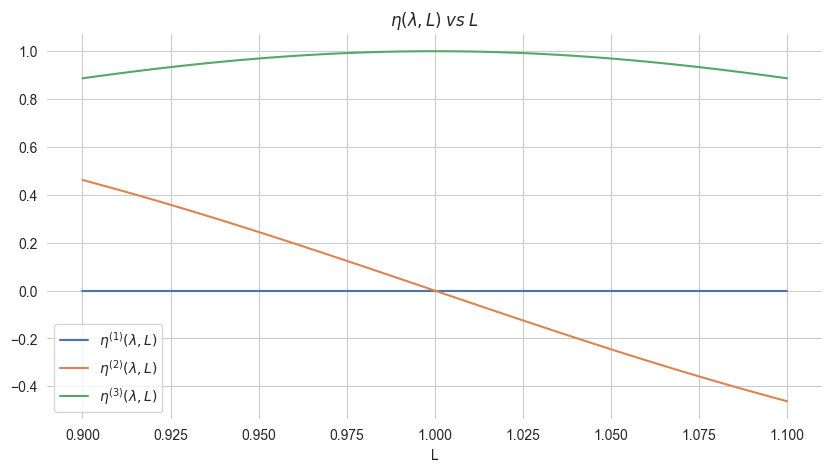

In [231]:
etas2 = [sym.Matrix((np.array(p_[:-1])/sym.sinh(sym.acosh(p_[-1])))) for p_ in p3]
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0.9,1.1,50), np.array(etas2).T[0].astype('float64').T)
plt.legend([r'$\eta^{(1)}(\lambda,L)$',r'$\eta^{(2)}(\lambda,L)$',r'$\eta^{(3)}(\lambda,L)$'])
plt.xlabel('L')
plt.title(r'$\eta(\lambda, L) \;vs\; L$')
sns.despine(bottom=True, left=True)

In [227]:
np.argmin(np.abs(np.array(etas2).T[0][1]))

np.int64(25)

In [228]:
np.linspace(0.9999,1.0001,50)[25]

np.float64(1.0000020408163266)

In [229]:
D3 = SeriesProd(LinearDevelopmentSeries([0,-1,0],1.0000020408163266,50), D2)

In [241]:
p4 = [SeriesSum(ScaledSeries(SeriesProd(LinearDevelopmentSeries([0,0,-1],L,50),D3),3))*o(4) for L in np.linspace(0.9999,1.0001,50)]

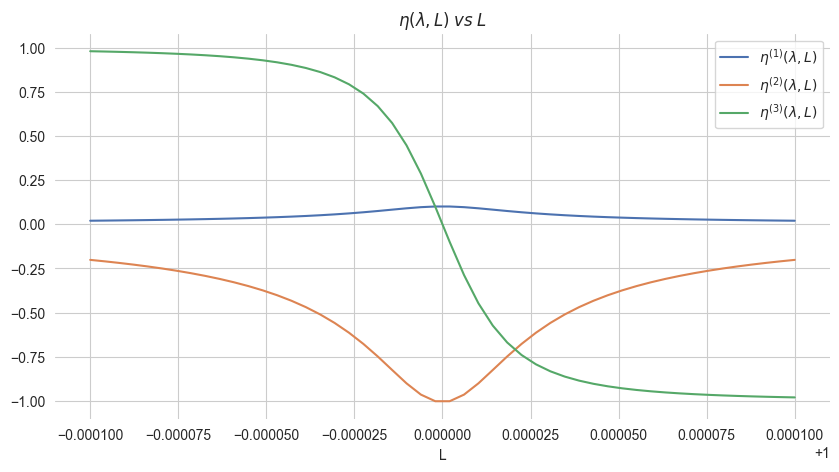

In [242]:
etas3 = [sym.Matrix((np.array(p_[:-1])/sym.sinh(sym.acosh(p_[-1])))) for p_ in p4]
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0.9999,1.0001,50), np.array(etas3).T[0].astype('float64').T)
plt.legend([r'$\eta^{(1)}(\lambda,L)$',r'$\eta^{(2)}(\lambda,L)$',r'$\eta^{(3)}(\lambda,L)$'])
plt.xlabel('L')
plt.title(r'$\eta(\lambda, L) \;vs\; L$')
sns.despine(bottom=True, left=True)

In [246]:
np.linspace(0.9999,1.0001,50)[np.argmin(np.abs(np.array(etas3).T[0][2]))]

np.float64(0.9999979591836735)